# AstroPrism Tutorial: Pipeline Example

This tutorial walks through the complete AstroPrism pipeline for multi-wavelength astronomical image modeling using Gaussian Processes.

**What you'll learn:**
1. Loading and organizing multi-channel astronomical data
2. Building Gaussian Process priors for the sky model
3. Modeling instrument response (reprojection + PSF convolution)
4. Constructing the forward model and likelihood
5. Running Bayesian inference with VI and NIFTy

## Environment

To run this tutorial, create a virtual environment and install AstroPrism in editable mode:

```bash
cd /path/to/astroprism

# Create and activate a virtual environment
python3 -m venv .venv
source .venv/bin/activate

# Install AstroPrism with dev dependencies
pip install -e ".[dev]"

# Register the Jupyter kernel
python -m ipykernel install --user --name=astroprism
```

Then select the **astroprism** kernel in Jupyter or VS Code.

## Imports

In [2]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import warnings
from astropy.utils.exceptions import AstropyWarning

import jax
import jax.numpy as jnp
import jax.random as jr
import nifty8.re as jft

warnings.filterwarnings('ignore', category=AstropyWarning)

### 1. Data Loading

SingleInstrumentDataset Summary:
--------------------------------
Number of channels: 4
Channel keys: ['F1000W_full', 'F1130W_full', 'F2100W_full', 'F770W_full']
Channel shapes: [(600, 600), (600, 600), (600, 600), (600, 600)]
Pixel scales: [(0.11091449975820492, 0.1109144997630491), (0.11091449949791077, 0.11091449946799463), (0.11091449907273217, 0.11091449905375952), (0.11091450012231652, 0.11091450010349585)]



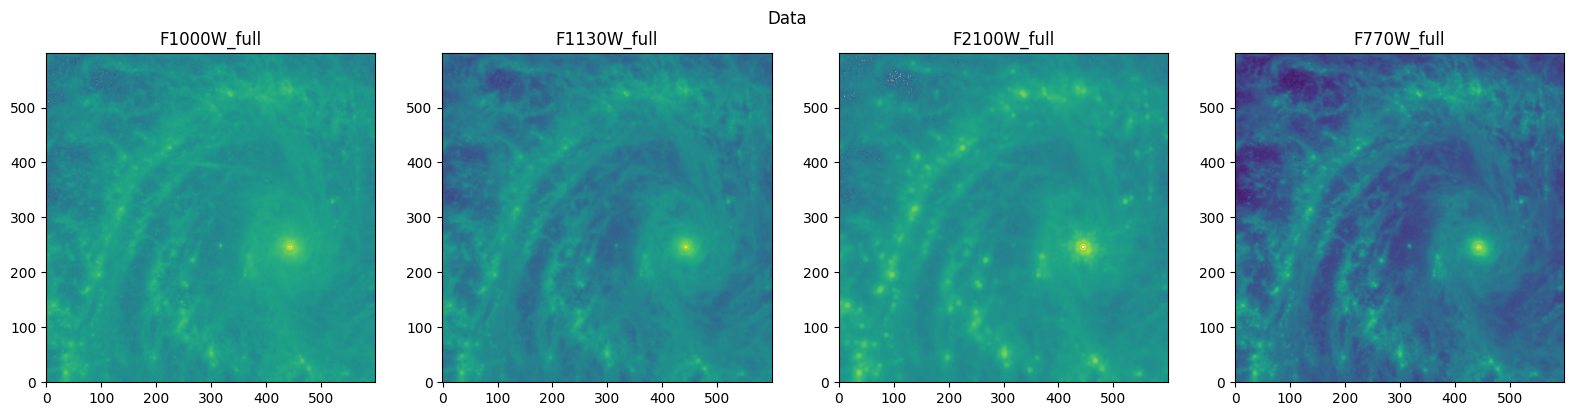

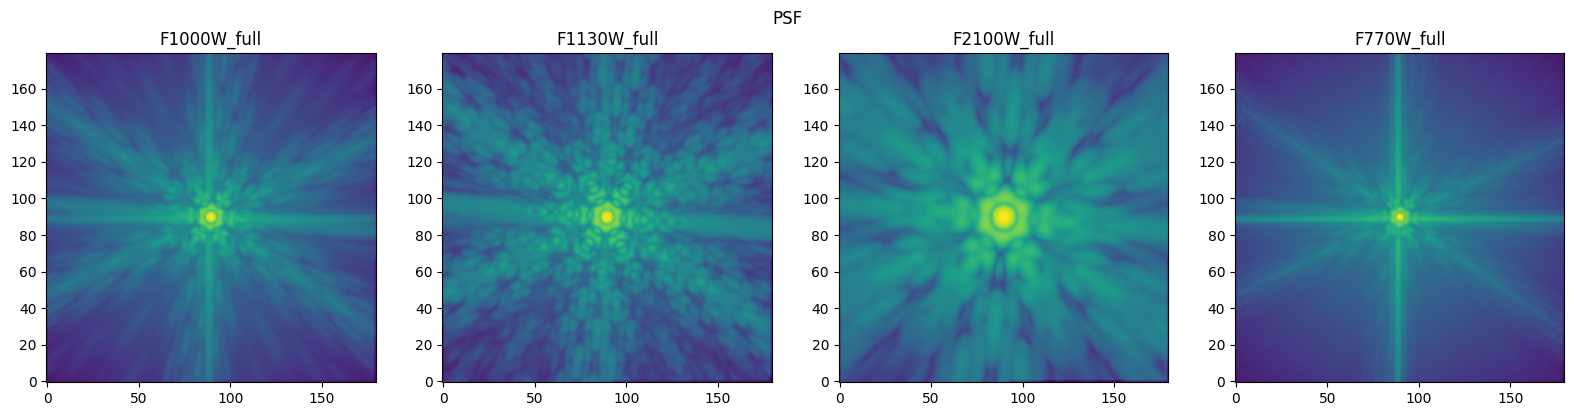

In [3]:
# Imports
from astroprism.io import load_dataset, SingleInstrumentDataset

# Load Single Instrument Dataset
path = "../data/tutorial/jwst_miri_cutout/"
dataset = load_dataset(path=path, instrument="JWST_MIRI", extension="fits")
print(dataset.summary())

# Plot Data
fig, axes = plt.subplots(1, dataset.n_channels, figsize=(4*dataset.n_channels, 4))
for i, key in enumerate(dataset.channel_keys):
    data, wcs, psf = dataset[key]
    axes[i].imshow(data, norm=LogNorm(), origin='lower')
    axes[i].set_title(key)
plt.suptitle("Data")
plt.tight_layout()
plt.show()

# Plot PSF
fig, axes = plt.subplots(1, dataset.n_channels, figsize=(4*dataset.n_channels, 4))

for i, key in enumerate(dataset.channel_keys):
    _, _, psf = dataset[key]
    axes[i].imshow(psf, norm=LogNorm(), origin='lower')
    axes[i].set_title(key)
plt.suptitle("PSF")
plt.tight_layout()
plt.show()

### 2. Set Up GP Prior

In [ ]:
# Imports
from astroprism.models.gp import SpatialGP, MixtureGP

# SpatialGP: a single-channel GP with spatial covariance
spatial_gp = SpatialGP(
    n_channels=len(dataset),
    shape=dataset.shapes[0],
    distances=dataset.pixel_scales[0],
)

# MixtureGP: a multi-channel GP with cross-channel covariance
mixture = MixtureGP(spatial_gps=spatial_gp)

# Print the domain of the MixtureGP (parameters)
print("MixtureGP domain keys:", list(mixture.domain.keys()))

### 3. Set Up the Instrument Response Model

In [ ]:
# Imports
from astroprism.models.response import InstrumentResponse

# Instrument Response Model: Reprojects the sky model to the observed frame and convolves with the PSF
response = InstrumentResponse(
    dataset=dataset,
    signal_wcs=dataset.wcs[0],
    signal_shape=dataset.shapes[0],
)

# Print the domain of the InstrumentResponse (parameters)
print("InstrumentResponse domain keys:", list(response.domain.keys()))

### 4. Set Up the Noise Model

In [ ]:
# Imports
from astroprism.models.noise import NoiseModel

# NoiseModel: Adds noise to the observed data
noise = NoiseModel(n_channels=len(dataset))

# Print the domain of the NoiseModel (parameters)
print("NoiseModel domain keys:", list(noise.domain.keys()))

### 5. Set Up the Forward Model

In [ ]:
# Imports
from astroprism.models.forward import ForwardModel

# ForwardModel: Combines all models
model = ForwardModel(mixture, response, noise)

# Print the domain of the ForwardModel (parameters)
print("ForwardModel domain keys:", list(model.domain.keys()))

### 6. Set Up the Likelihood and Run Inference

In [ ]:
# Imports
from astroprism.models.likelihood import build_likelihood
from astroprism.inference.vi import run_inference

# Build likelihood: Combines data, model, and mask (readout)
likelihood = build_likelihood(dataset, model, mask=dataset.readout)

# Run inference: Optimizes the likelihood 
samples, state = run_inference(
    likelihood, 
    n_iterations=10,   # number of iterations
    n_samples=2,      # number of samples
    seed=42,
    output_directory="tutorial_results"
)

### 7. Analyze the Posterior

In [ ]:
# Load inference results first to check what was saved
results_dir = Path("tutorial_results")
samples, state = pickle.load(open(results_dir / "last.pkl", "rb"))

# Posterior Mean
posterior_means = jft.mean(samples)

# Predicted signal
pred_signal_mean = mixture(posterior_means)

# Predicted data
pred_data_mean = response(posterior_means, pred_signal_mean)

# Residuals
residuals = jnp.array(dataset.data) - jnp.array(pred_data_mean)

# Plot Predicted Signal
fig, axes = plt.subplots(1, dataset.n_channels, figsize=(4*dataset.n_channels, 4))
for i in range(dataset.n_channels):
    axes[i].imshow(pred_signal_mean[i], origin='lower', norm=LogNorm())
    axes[i].set_title(dataset.channel_keys[i])
plt.suptitle("Predicted Signal")
plt.tight_layout()

# Plot Predicted Data
fig, axes = plt.subplots(1, dataset.n_channels, figsize=(4*dataset.n_channels, 4))
for i in range(dataset.n_channels):
    axes[i].imshow(pred_data_mean[i], origin='lower', norm=LogNorm())
    axes[i].set_title(dataset.channel_keys[i])
plt.suptitle("Predicted Data")
plt.tight_layout()

# Plot Actual Data
fig, axes = plt.subplots(1, dataset.n_channels, figsize=(4*dataset.n_channels, 4))
for i, key in enumerate(dataset.channel_keys):
    data, wcs, psf = dataset[key]
    axes[i].imshow(data, norm=LogNorm(), origin='lower')
    axes[i].set_title(key)
plt.suptitle("Data")
plt.tight_layout()
plt.show()

# Plot Residuals
fig, axes = plt.subplots(1, dataset.n_channels, figsize=(4*dataset.n_channels, 4))
for i in range(dataset.n_channels):
    axes[i].imshow(residuals[i], origin='lower')
    axes[i].set_title(dataset.channel_keys[i])
plt.suptitle("Residuals")
plt.tight_layout()

## Summary

In this tutorial, you learned the complete AstroPFM pipeline:

| Step | Component | Purpose |
|------|-----------|---------|
| 1 | Dataset | Load and organize multi-channel data |
| 2 | MixtureGP | Gaussian Process prior for sky model |
| 3 | InstrumentResponse | Reprojection + PSF convolution |
| 4 | NoiseModel | Heteroscedastic noise modeling |
| 5 | ForwardModel | Combine all components |
| 6 | Likelihood & Inference | Connect model to data and perform Bayesian inference|
| 7 | Analysis | Visualize and interpret results |